# LabFBI

Given an irreducible area (e.g, a pixel) with:
- $n_s$ chelated molecules
- $n_b$ unchelated molecules

Iluminated by a laser beam of photon density I, we find that:

$\gamma_s = n_s \sigma_s^c Q^c = n_s B^c$

$\gamma_b = n_b \sigma_s^u Q^u = n_b B^u$

Where $\gamma_s$ is the number of photons emitted by the signal and $\gamma_b$ is the number of photons emitted by the background, $B$ is the total brightness ($B^c$ for chelated molecules, $B^u$ for unchelated molecules).

If the optical system has an overall geometrical acceptance of $\epsilon_g$, and a detection efficiency of $\epsilon_d$ the number of recorded photons in the corresponding detector (e.g, a pixel in the CCD) is:

$N_s =  n_s B^c \epsilon $

$N_b =  n_b B^u \epsilon $

Where $\epsilon = \epsilon_g \epsilon_d$.

The observed signal in the selection **color band** (e.g 420-430 nm for G1, 520 - 540 nm for G2) is:

$S =  n_s B^c \epsilon_b^c \epsilon $
$B =  n_b B^u \epsilon_b^u \epsilon $

where $\epsilon_b^c$ is the efficiency to be in the band for chelated molecules and \epsilon_b^u$ is the efficiency to be in the band for unchelated molecules


## Relevant data

### Sample concentrations

Solution : FBI/FBI-Ba: 5 x 10^-5 mol/L

Powder   : FBI: 2.25 x 10^-5 mmol/mg  --> 50 mg/cm2

         : FBI-BA: 7.38 x 10^-8 mm/mg
         
         : Ba: 5.85 x 10^-5 mm/mg
         
PELLETS  : FBI-- 7.4 x 10^-8 mm/mg ---> 36.74 mg: D = 10 mm

         : Homeopatic: 7.4 x 10^-15 mm/mg ---> 36.74 mg: D = 10 mm
         
         350 mm 
         25.4
         

In [45]:
40.0/(π * 25)

0.5092958178940651

In [1]:
begin
    using Test
    using Plots
    using LsqFit
    using Interpolations
    using Images
    using ImageIO
    using ImageView
    using CSV
    using DataFrames
end

In [6]:
import Pkg; Pkg.add("UnitfulMoles")

   Updating registry at `~/.julia/registries/General`
######################################################################### 100.0%
   Updating registry at `~/.julia/registries/JuliaComputingRegistry`
  Resolving package versions...
  Installed Qt_jll ─────── v5.15.2+3
  Installed UnitfulMoles ─ v0.1.0
Updating `~/JuliaProjects/LabFBI/Project.toml`
  [999f2bd7] + UnitfulMoles v0.1.0
Updating `~/JuliaProjects/LabFBI/Manifest.toml`
  [ede63266] ↑ Qt_jll v5.15.2+2 ⇒ v5.15.2+3
  [999f2bd7] + UnitfulMoles v0.1.0


In [7]:
begin
    using Unitful
    using UnitfulEquivalences
    using UnitfulMoles
end

┌ Info: Precompiling UnitfulMoles [999f2bd7-36bf-5ba7-9bc1-c9473aa75374]
└ @ Base loading.jl:1278


In [8]:
using DrWatson

In [9]:
@quickactivate "LabFBI"

## Units

In [36]:
import Unitful:
    nm, μm, mm, cm, m, km, inch, ft, mi,
    L,
    ac,
    mg, g, kg,
    Ra, °F, °C, K,
    rad, °,
    ns, μs, ms, s, minute, hr, d, yr, Hz,
    eV,
    μJ, mJ, J, 
    mW, W,
    A, N, mol, mmol, V


- To convert a number to the desired unit multiply by the unit, divide to remove. 

In [11]:
x = 3*mm

3 mm

In [12]:
typeof(x)

Quantity{Int64,𝐋,Unitful.FreeUnits{(mm,),𝐋,nothing}}

In [9]:
typeof(x)

Float64

In [13]:
x/mm

3

In [14]:
typeof(x/mm)

Int64

- We can convert between equivalent energy systems (e.g, SI to natural units). For example, the wavelength of a phothon of 1 eV and viceversa

In [15]:
uconvert(nm, 1.0eV, Spectral())

1239.8419843320028 nm

In [16]:
typeof(L)

Unitful.FreeUnits{(L,),𝐋³,nothing}

In [17]:
typeof(m^2)

Unitful.FreeUnits{(m²,),𝐋²,nothing}

In [ ]:
module 

## Setup

<img src="laserFBI.png"> 

## Laser

In [18]:
struct Laser
    λ::typeof(1.0nm) # declare λ to be in nm
    P::typeof(1.0mW) # power
end

In [19]:
l400p1 = Laser(405.0nm, 1.0mW) 

Laser(405.0 nm, 1.0 mW)

In [20]:
@test l400p1.λ == 405.0nm

Test Passed

In [21]:
@test l400p1.P == 1.0mW

Test Passed

### Photon energy as a function of laser $\lambda$

In [22]:
function photon_energy(λ::Quantity) 
    uconvert(eV, λ, Spectral()) 
end

photon_energy (generic function with 1 method)

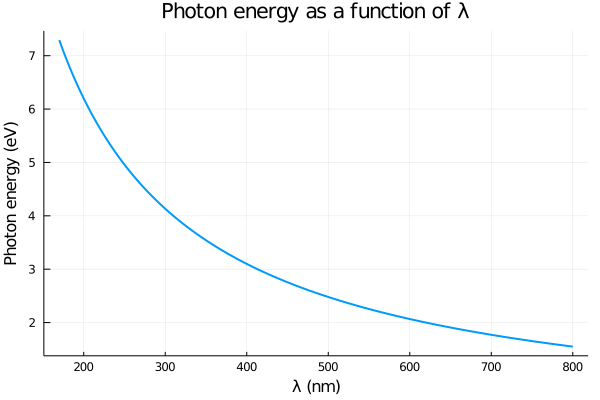

In [24]:
Λ =collect(170:1:800) * nm
PE = photon_energy.(Λ)
plot(Λ./nm, PE./eV, leg=false,lw=2)
xlabel!("λ (nm)")
ylabel!("Photon energy (eV)")
title!("Photon energy as a function of λ")

### Number of photons per unit time as a function of power

In [25]:
n_photons(l::Laser) = uconvert(Hz, l.P / photon_energy(l.λ))

n_photons (generic function with 1 method)

In [26]:
n_photons(l400p1)

2.0388172098547972e15 Hz

In [27]:
n_photons(λ::Quantity, p::Quantity) = uconvert(Hz, p / photon_energy(λ))

n_photons (generic function with 2 methods)

In [28]:
n_photons(400nm, 10mW)

2.013646627017084e16 Hz

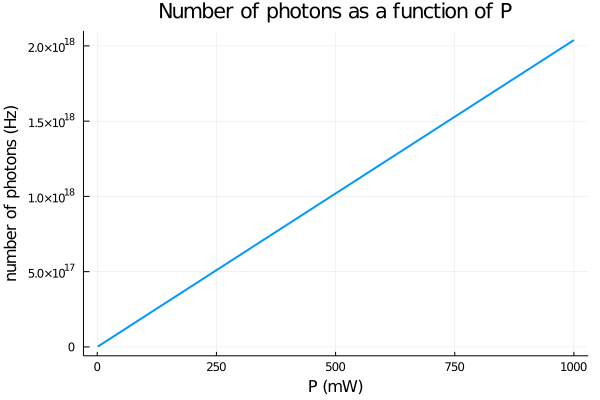

In [29]:
P =collect(1:1:10^3) * mW
NP = n_photons.((405nm,), P )
plot(P./mW, NP./Hz, leg=false,lw=2)
xlabel!("P (mW)")
ylabel!("number of photons (Hz)")
title!("Number of photons as a function of P")

## Samples

### Solution

In [30]:
struct Solution
    name::String
    c::typeof(1.0mol/L) # concentration
end

In [31]:
sfbi = Solution("FBI-Standard-Solution", 5e-5mol/L)

Solution("FBI-Standard-Solution", 5.0e-5 mol L⁻¹)

In [33]:
@test sfbi.name=="FBI-Standard-Solution"

Test Passed

In [34]:
@test sfbi.c == 5e-5mol/L

Test Passed

In [35]:
sfbiba = Solution("FBIBa-Standard-Solution", 5e-5mol/L)

Solution("FBIBa-Standard-Solution", 5.0e-5 mol L⁻¹)

### Powder

In [37]:
struct Powder
    name::String
    cs::typeof(1.0mmol/mg) # concentration to substrate
    rs::typeof(1.0mg/cm^2) # concentration per area
end

In [38]:
pfbi = Powder("FBI-Standard", 2.25e-5mmol/mg, 50mg/cm^2)

Powder("FBI-Standard", 2.25e-5 mmol mg⁻¹, 50.0 mg cm⁻²)

In [39]:
pfbiba = Powder("FBIBa-Standard", 7.38e-8mmol/mg, 50mg/cm^2)

Powder("FBIBa-Standard", 7.38e-8 mmol mg⁻¹, 50.0 mg cm⁻²)

In [40]:
hpfbi = Powder("FBI-Homeopatic", 7.4e-15mmol/mg, 50mg/cm^2)

Powder("FBI-Homeopatic", 7.4e-15 mmol mg⁻¹, 50.0 mg cm⁻²)

### Molecule

In [43]:
struct Molecule
        name::String
        ex::typeof(1.0nm) # peak excitation
        en::typeof(1.0nm) # peak emission
        ϵ::typeof(1.0mg/(mol*cm)) # molar extinction coefficient
        Q::Float64 # Quantum efficiency
end

LoadError: [91minvalid redefinition of constant Molecule[39m

In [ ]:
qdot525 = Molecule("Qdot525",)

Solution : FBI/FBI-Ba: 5 x 10^-5 mol/L
Powder   : FBI: 2.25 x 10^-5 mmol/mg  --> 50 mg/cm2
         : FBI-BA: 7.38 x 10^-8 mm/mg
         : Ba: 5.85 x 10^-5 mm/mg
PELLETS  : FBI-- 7.4 x 10^-8 mm/mg ---> 36.74 mg: D = 10 mm
         : Homeopatic: 7.4 x 10^-15 mm/mg ---> 36.74 mg: D = 10 mm